In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [17]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [18]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


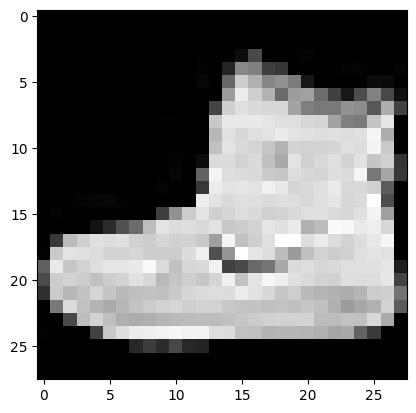

In [28]:
import matplotlib.pyplot as plt

def show_data(data):
  plt.imshow(data[0][0].squeeze(), cmap="gray")
  plt.show()

show_data(training_data[0])

In [20]:
training_data[0][1]

9

In [21]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [22]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [23]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [29]:
# count the number of parameters in the model

print(sum(p.numel() for p in model.parameters()))

669706


In [32]:
(1 - 0.0879) * 1e-3

0.0009121

In [38]:
torch.max(torch.softmax(model(training_data[0][0]), dim=-1), dim=-1)

torch.return_types.max(
values=tensor([0.6843], grad_fn=<MaxBackward0>),
indices=tensor([9]))

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [34]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [35]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [40]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.788125  [   64/60000]
loss: 0.868665  [ 6464/60000]
loss: 0.630608  [12864/60000]
loss: 0.832697  [19264/60000]
loss: 0.740793  [25664/60000]
loss: 0.736778  [32064/60000]
loss: 0.817950  [38464/60000]
loss: 0.799076  [44864/60000]
loss: 0.784943  [51264/60000]
loss: 0.760988  [57664/60000]
Test Error: 
 Accuracy: 72.0%, Avg loss: 0.758979 

Epoch 2
-------------------------------
loss: 0.750181  [   64/60000]
loss: 0.838983  [ 6464/60000]
loss: 0.599141  [12864/60000]
loss: 0.806913  [19264/60000]
loss: 0.718900  [25664/60000]
loss: 0.710859  [32064/60000]
loss: 0.792187  [38464/60000]
loss: 0.782718  [44864/60000]
loss: 0.762177  [51264/60000]
loss: 0.738926  [57664/60000]
Test Error: 
 Accuracy: 73.1%, Avg loss: 0.736263 

Epoch 3
-------------------------------
loss: 0.717203  [   64/60000]
loss: 0.812222  [ 6464/60000]
loss: 0.572331  [12864/60000]
loss: 0.785132  [19264/60000]
loss: 0.700044  [25664/60000]
loss: 0.689447  [32064/600

In [41]:
test(train_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.664216 

